# Case Study 2: Human-in-The-Loop Pneumonia Detection Using Chest X-Ray Images

## 1. Packages

In [39]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

## 2. Load data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

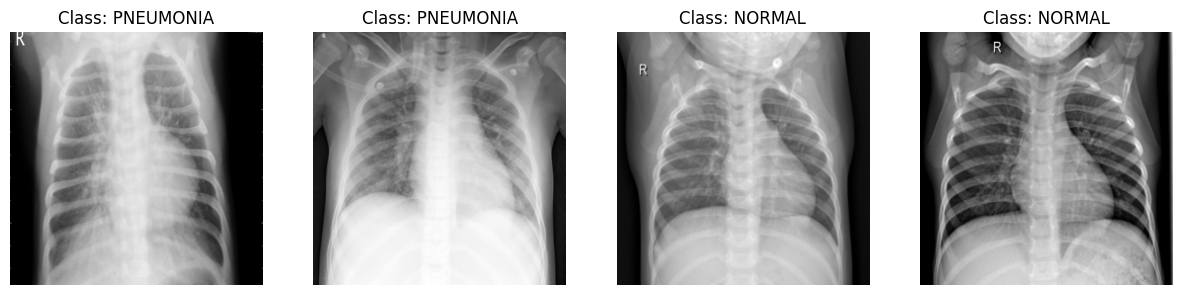

In [23]:
# Define a simple dataset class
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.labels = []
        self.image_files = []

        # Load image file paths and labels
        for index, label in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, label)
            for filename in os.listdir(class_dir):
                self.image_files.append(os.path.join(class_dir, filename))
                self.labels.append(index)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert('L')  # Convert image to grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Setup the dataset
dataset = ChestXrayDataset(root_dir='./chest_xray/train', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Function to show images
def show_images(images, labels, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, (img, label) in enumerate(zip(images, labels)):
        ax = axes[i]
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Class: {dataset.classes[label]}')
        ax.axis('off')
    plt.show()

# Get a batch of training data
images, labels = next(iter(dataloader))
show_images(images, labels)


## 3. Simple CNN 

### 3.1 Build model

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # input is grayscale
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 32 * 32)  # flatten image input
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 3.2 Model training

In [15]:
train_set = ChestXrayDataset(root_dir='./chest_xray/train', transform=transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)


test_set = ChestXrayDataset(root_dir='./chest_xray/test', transform=transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [13]:
# Initialize the model, loss criterion, and optimizer
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
cnn = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

# Training the model
num_epochs = 30
for epoch in range(num_epochs):
    cnn.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

print("Training complete")

Epoch 1, Loss: 0.26016786485407617
Epoch 2, Loss: 0.11731832753866911
Epoch 3, Loss: 0.08553979113309479
Epoch 4, Loss: 0.07149470874474047
Epoch 5, Loss: 0.05125844606556901
Epoch 6, Loss: 0.05104613003708091
Epoch 7, Loss: 0.038622463122367334
Epoch 8, Loss: 0.029411224142164048
Epoch 9, Loss: 0.022555759147150967
Epoch 10, Loss: 0.013349560403525387
Epoch 11, Loss: 0.022071438837872603
Epoch 12, Loss: 0.008064915172644481
Epoch 13, Loss: 0.013608313933826088
Epoch 14, Loss: 0.010160806594798866
Epoch 15, Loss: 0.0027770316906416005
Epoch 16, Loss: 0.00027845990980264956
Epoch 17, Loss: 8.137877211056981e-05
Epoch 18, Loss: 4.557252836901847e-05
Epoch 19, Loss: 3.1760126491017016e-05
Epoch 20, Loss: 2.6054616842748282e-05
Epoch 21, Loss: 2.1507346267539885e-05
Epoch 22, Loss: 1.8205925689630444e-05
Epoch 23, Loss: 1.5452241202488098e-05
Epoch 24, Loss: 1.3385379978734617e-05
Epoch 25, Loss: 1.181803993443733e-05
Epoch 26, Loss: 1.0007088252921346e-05
Epoch 27, Loss: 8.277306452549047

In [ ]:
# Save the trained model
torch.save(cnn.state_dict(), 'pneumonia_detection_model_CNN.pth')

In [16]:
# Assuming the model architecture is defined as SimpleCNN
cnn = SimpleCNN()
cnn.load_state_dict(torch.load('pneumonia_detection_model_CNN.pth'))
cnn.to(device)
cnn.eval()  # Set the model to evaluation mode

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
)

In [16]:
from sklearn.metrics import roc_auc_score

# Assuming test_loader is defined and ready with test data
y_pred = []
y_true = []

# Disable gradient computation since we are in inference mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1 (PNEUMONIA)
        y_pred.extend(probabilities.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred)
print(f'The AUC score on the test set is: {auc_score:.4f}')


The AUC score on the test set is: 0.7931


### 3.3 Export predictions

In [34]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Assuming the dataset path and structure is already correct
class SimpleDataset:
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        for label, cls in enumerate(['NORMAL', 'PNEUMONIA']):
            path = os.path.join(root_dir, cls)
            for file in os.listdir(path):
                if file.endswith('.jpeg'):
                    self.images.append(os.path.join(path, file))
                    self.labels.append(label)  # 0 for NORMAL, 1 for PNEUMONIA

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx], os.path.basename(self.images[idx])

# Load the dataset
dataset = SimpleDataset(root_dir='./chest_xray/test', transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [49]:
results = []

cnn.eval()
with torch.no_grad():
    for inputs, labels, filenames in loader:
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = cnn(inputs)
        probabilities = F.softmax(outputs, dim=1)  # Compute probabilities
        _, predicted = torch.max(outputs, 1)
        
        # Collect filenames, actual labels, predictions, and probabilities for class "0-NORMAL"
        results.append([
            filenames[0], 
            labels.item(),
            predicted.item(), 
            probabilities[0, 1].item()  # Probability of being "1-PNEUMONIA"
        ])

df = pd.DataFrame(results, columns=['Filename', 'Ground Truth', 'Prediction', 'Prob_1_PNEUMONIA'])
df.to_csv('results_cnn.csv', index=False)

In [50]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# Load the results from CSV
df = pd.read_csv('results_cnn.csv')

# Extract the ground truth labels and the probabilities for class "0-NORMAL"
y_true = df['Ground Truth']
y_scores = df['Prob_1_PNEUMONIA']

# Compute the AUC
auc_score = roc_auc_score(y_true, y_scores)
print(f"The AUC score is: {auc_score:.4f}")

The AUC score is: 0.7931


## 4. ResNet

### 4.1 Build model

In [46]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

### 4.2 Model training

In [5]:
train_set = ChestXrayDataset(root_dir='./chest_xray/train', transform=transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)


test_set = ChestXrayDataset(root_dir='./chest_xray/test', transform=transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [6]:
# Initialize the model, loss criterion, and optimizer
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
resnet = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

In [7]:
# Training the model
num_epochs = 30
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

print("Training complete")

Epoch 1, Loss: 0.23395032202539268
Epoch 2, Loss: 0.13516105402352438
Epoch 3, Loss: 0.11202047246456878
Epoch 4, Loss: 0.09461958544111691
Epoch 5, Loss: 0.08365025697561677
Epoch 6, Loss: 0.08058391909394985
Epoch 7, Loss: 0.06199187911515541
Epoch 8, Loss: 0.07125519788281226
Epoch 9, Loss: 0.044449418510004675
Epoch 10, Loss: 0.048021626424835706
Epoch 11, Loss: 0.04409150795388304
Epoch 12, Loss: 0.03908518088682972
Epoch 13, Loss: 0.02980734622332716
Epoch 14, Loss: 0.03743584812608079
Epoch 15, Loss: 0.026651435600685818
Epoch 16, Loss: 0.03213280123394937
Epoch 17, Loss: 0.030189411180983783
Epoch 18, Loss: 0.018351612596937236
Epoch 19, Loss: 0.014513654926823213
Epoch 20, Loss: 0.019131262949034014
Epoch 21, Loss: 0.01757120493268437
Epoch 22, Loss: 0.007698049905698405
Epoch 23, Loss: 0.016969234554431036
Epoch 24, Loss: 0.009641778116192821
Epoch 25, Loss: 0.014195144653080697
Epoch 26, Loss: 0.015226490392008718
Epoch 27, Loss: 0.010765282078429184
Epoch 28, Loss: 0.010807

In [9]:
# Save the trained model
torch.save(resnet.state_dict(), 'pneumonia_detection_model_resnet.pth')

In [48]:
# Assuming the model architecture is defined as SimpleCNN
resnet = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=2)
resnet.load_state_dict(torch.load('pneumonia_detection_model_resnet.pth'))
resnet.to(device)
resnet.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

In [11]:
from sklearn.metrics import roc_auc_score

# Assuming test_loader is defined and ready with test data
y_pred = []
y_true = []

# Disable gradient computation since we are in inference mode
resnet.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1 (PNEUMONIA)
        y_pred.extend(probabilities.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred)
print(f'The AUC score on the test set is: {auc_score:.4f}')

The AUC score on the test set is: 0.9240


### 4.3 Export prediction

In [47]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Assuming the dataset path and structure is already correct
class SimpleDataset:
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        for label, cls in enumerate(['NORMAL', 'PNEUMONIA']):
            path = os.path.join(root_dir, cls)
            for file in os.listdir(path):
                if file.endswith('.jpeg'):
                    self.images.append(os.path.join(path, file))
                    self.labels.append(label)  # 0 for NORMAL, 1 for PNEUMONIA

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx], os.path.basename(self.images[idx])

# Load the dataset
dataset = SimpleDataset(root_dir='./chest_xray/test', transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [52]:
results = []

resnet.eval()
with torch.no_grad():
    for inputs, labels, filenames in loader:
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = resnet(inputs)
        probabilities = F.softmax(outputs, dim=1)  # Compute probabilities
        _, predicted = torch.max(outputs, 1)
        
        # Collect filenames, actual labels, predictions, and probabilities for class "0-NORMAL"
        results.append([
            filenames[0], 
            labels.item(),
            predicted.item(), 
            probabilities[0, 1].item()  # Probability of being "1-PNEUMONIA"
        ])

df = pd.DataFrame(results, columns=['Filename', 'Ground Truth', 'Prediction', 'Prob_1_PNEUMONIA'])
df.to_csv('results_resnet.csv', index=False)

In [53]:
from sklearn.metrics import roc_auc_score

# Load the results from CSV
df = pd.read_csv('results_resnet.csv')

# Extract the ground truth labels and the probabilities for class "0-NORMAL"
y_true = df['Ground Truth']
y_scores = df['Prob_1_PNEUMONIA']

# Compute the AUC
auc_score = roc_auc_score(y_true, y_scores)
print(f"The AUC score is: {auc_score:.4f}")

The AUC score is: 0.9240
